In [1]:
import tensorflow as tf 
from tensorflow.keras import datasets,layers,models

BATCH_SIZE = 100

def load_image(img_path,size = (32,32)):
    label = tf.constant(1,tf.int8) if tf.strings.regex_full_match(img_path,".*automobile.*") \
            else tf.constant(0,tf.int8)
    img = tf.io.read_file(img_path)
#     print(img)
    img = tf.image.decode_jpeg(img) #注意此处为jpeg格式
    img = tf.image.resize(img,size)/255.0
    return(img,label)

In [2]:
#使用并行化预处理num_parallel_calls 和预存数据prefetch来提升性能
ds_train = tf.data.Dataset.list_files("./data/cifar2/train/*/*.jpg") \
           .map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
           .shuffle(buffer_size = 1000).batch(BATCH_SIZE) \
           .prefetch(tf.data.experimental.AUTOTUNE)  

ds_test = tf.data.Dataset.list_files("./data/cifar2/test/*/*.jpg") \
           .map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
           .batch(BATCH_SIZE) \
           .prefetch(tf.data.experimental.AUTOTUNE)  

print(ds_train)
print(ds_test)

Tensor("ReadFile:0", shape=(), dtype=string)
Tensor("ReadFile:0", shape=(), dtype=string)
<PrefetchDataset shapes: ((None, 32, 32, None), (None,)), types: (tf.float32, tf.int8)>
<PrefetchDataset shapes: ((None, 32, 32, None), (None,)), types: (tf.float32, tf.int8)>


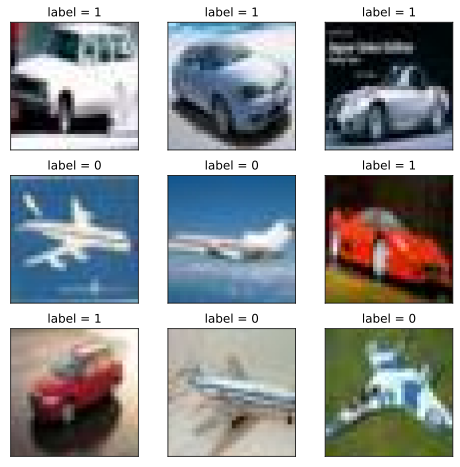

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

#查看部分样本
from matplotlib import pyplot as plt 

plt.figure(figsize=(8,8)) 
for i,(img,label) in enumerate(ds_train.unbatch().take(9)):
    ax=plt.subplot(3,3,i+1)
    ax.imshow(img.numpy())
    ax.set_title("label = %d"%label)
    ax.set_xticks([])
    ax.set_yticks([]) 
plt.show()

In [4]:
tf.keras.backend.clear_session() #清空会话

inputs = layers.Input(shape=(32,32,3))
x = layers.Conv2D(32,kernel_size=(3,3))(inputs)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(64,kernel_size=(5,5))(x)
x = layers.MaxPool2D()(x)
x = layers.Dropout(rate=0.1)(x)
x = layers.Flatten()(x)
x = layers.Dense(32,activation='relu')(x)
outputs = layers.Dense(1,activation = 'sigmoid')(x)

model = models.Model(inputs = inputs,outputs = outputs)

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)             

In [5]:
import datetime
import os

stamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = os.path.join('data', 'autograph', stamp)

## 在 Python3 下建议使用 pathlib 修正各操作系统的路径
# from pathlib import Path
# stamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# logdir = str(Path('./data/autograph/' + stamp))

tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=tf.keras.losses.binary_crossentropy,
        metrics=["accuracy"]
    )

history = model.fit(ds_train,epochs= 10,validation_data=ds_test,
                    callbacks = [tensorboard_callback],workers = 4)

Epoch 1/10
  1/100 [..............................] - ETA: 0s - loss: 0.7269 - accuracy: 0.4600WARNING:tensorflow:From d:\anaconda3\envs\env\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
100/100 [==============================] - 8s 77ms/step - loss: 0.4323 - accuracy: 0.7933 - val_loss: 0.3458 - val_accuracy: 0.8425
Epoch 2/10
100/100 [==============================] - 7s 70ms/step - loss: 0.3244 - accuracy: 0.8555 - val_loss: 0.3050 - val_accuracy: 0.8655
Epoch 3/10
100/100 [==============================] - 7s 69ms/step - loss: 0.2720 - accuracy: 0.8848 - val_loss: 0.2374 - val_accuracy: 0.9005
Epoch 4/10
100/100 [==============================] - 7s 70ms/step - loss: 0.2246 - accuracy: 0.9092 - val_loss: 0.2151 - val_accuracy: 0.9095
Epoch 5/10
100/100 [==============================] - 7s 70ms/ste

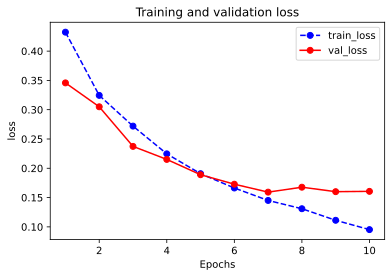

In [6]:
import matplotlib.pyplot as plt

def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

plot_metric(history,"loss")

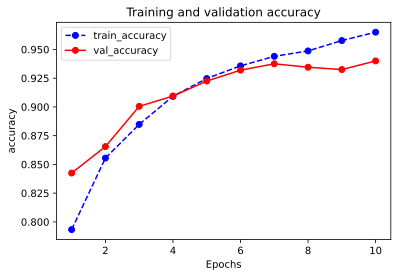

In [7]:
plot_metric(history,"accuracy")